In [1]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

from spectrum import arburg, arma2psd
import pylab

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:3168: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc')
octave.addpath(eeglab_path + 'popfunc')
octave.addpath(eeglab_path + 'adminfunc')
octave.addpath(eeglab_path + 'sigprocfunc')
octave.addpath(eeglab_path + 'miscfunc')

'.:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/sigprocfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/adminfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/popfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/guifunc:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/oct2py:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/octave_kernel:/usr/lib/x86_64-linux-gnu/octave/4.2.2/site/oct/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/api-v51/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/site/m:/usr/share/octave/site/api-v51/m:/usr/share/octave/site/m:/usr/share/octave/site/m/startup:/usr/lib/x86_64-linux-gnu/octave/4.2.2/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/m:/usr/share/octave/4.2.2/m/audio:/usr/share/octave/4.2.2/m/debian:/usr/share/octave/4.2.2/m/deprecated:/usr/share/octave/4.2.2/m/elfun:/usr/share/octave/4.2.2/m/general:/usr/share/octave/4.2

In [3]:
eegs = ['data/original/sub03/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
#  'data/original/sub05/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set', # NO MEP
#  'data/original/sub05/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set', # NO MEP
 'data/original/sub05/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub06/exp02/eeg/SP 110RMT/05-clean-prestimulus.set',
 'data/original/sub07/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub07/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub07/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub08/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub08/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub08/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub08/exp02/eeg/SP 110RMT/05-clean-prestimulus.set',
 'data/original/sub08/exp03/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub08/exp03/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub08/exp03/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub09/exp01/eeg/SP 110RMT/05-clean-prestimulus.set',
 'data/original/sub10/exp01/eeg/SP 110RMT/05-clean-prestimulus.set',
 'data/original/sub10/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub10/exp02/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub10/exp02/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub11/exp01/eeg/SP 110RMT/05-clean-prestimulus.set',
 'data/original/sub11/exp02/eeg/SP 110RMT/05-clean-prestimulus.set',
 'data/original/sub12/exp01/eeg/SP 110RMT/05-clean-prestimulus.set',
 'data/original/sub12/exp02/eeg/SP 110RMT/05-clean-prestimulus.set',
#  'data/original/sub13/exp01/eeg/SP 110RMT/05-clean-prestimulus.set', # LEFT HANDED
 'data/original/sub14/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub15/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub15/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub15/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
 'data/original/sub16/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
 'data/original/sub16/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
 'data/original/sub16/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set'
]

 # Read and process EEG

In [167]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, 0, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

def band_max(freq, psd, interval):
    indices = []
    for el in freq:
        indices.append(el in interval)
    freq = freq[indices]
    psd = psd[indices]
    if (len(psd) == 0):
        return 0, 0
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

def crop_mep_region(mep_frame):
    crop_start = 0.211
    crop_end = 0.4
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped, time

def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

def get_mep_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    return mep_path

def calculate_mep_size(mep_frame):
    mep_cropped, time = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size, min_row, max_row

# Read CMAP file.
def read_cmap(path):
    df = pd.read_excel(path, sheet_name='Raw data', header=None)
    columns = []
    ix = 0
    for r in df.index.values:
        if df[0][r] == 'Channel':
            ix = r
            break
    for c in df.columns.values:
        if (df[c][ix] == 2):
            columns.append(c)
    for r in df.index.values:
        if df[0][r] == 'Time (ms)':
            ix = r
            break
    df2 = df[columns].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    df2['time'] = df[0].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    return df2

# Identify CMAP peaks.
def find_cmap_peaks(df):
    df2 = df[(df['time'] > 5) * (df['time'] < 20)]
    time = df2['time']
    mean_clean = df2.drop('time', axis=1).mean(axis=1)
    return mean_clean.max(), mean_clean.min()

def get_cmap_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'cmap'
    del segments[5]
    segments = segments[:-1]
    cmap_path = '/'.join(segments) + '/*.xlsx'
    cmap_paths = glob.glob(cmap_path)
    if (len(cmap_paths) == 0):
        print('No CMAP found for ' + cmap_path)
        return ''
    return cmap_paths[0]

def get_mep_category_absolute_binary(mep_size):
    if mep_size <= .5:
        return 0
    else:
        return 1
    
def calculate_mep_categories_binary(mep_sizes):
    p1 = np.percentile(mep_sizes, 50)
    cat = np.ones(len(mep_sizes)) * (mep_sizes >= p1)
    return cat

def calculate_mep_categories_cmap_binary(mep_sizes, cmap):
    sizes = []
    for mep_size in mep_sizes:
        sizes.append(mep_size / cmap)
    p1 = np.percentile(sizes, 50)
    cat = np.ones(len(mep_sizes)) * (sizes >= p1)
    return cat

def plot_freq_response(sig, time, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 3))
    ax1.plot(time/1000, sig)
    ax1.set(xlabel='Time (s)', ylabel="uV")
    ax1.set_title('Signal')
    
    fs = 1000/(time[1] - time[0])
    freq, fft = signal.welch(sig, fs, nperseg=4*fs)
    ax2.semilogy(freq, fft)
    ax2.set(xlabel='Frequency (Hz)', ylabel="Power")
    ax2.set_title('Welch PSD')
    
    fft = np.fft.fft(sig)
    freq = np.fft.fftfreq(len(sig), 1/fs)
    
    ax3.plot(freq, np.angle(fft))
    ax3.set(xlabel='Angle', ylabel="Power")
    ax3.set_title('Angle')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if title != None:
        plt.suptitle(title)
        
def blackman_harris(sig, time, numtaps, cutoff):
    fs = 1000 / (time[1] - time[0])
    x = np.concatenate((sig, np.ones(int(fs/2)) * sig[-1]))
    b = signal.firwin(numtaps, cutoff, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, x)
    delay = 0.5 * (numtaps - 1)
    filtered = filtered[numtaps-1:]
    filtered = filtered[0:int(len(filtered) - delay)]
    return filtered

def get_phase(channel, time, band, N=1023):
    filtered_band = blackman_harris(channel.values, time, N, [0.00001, band[0]])
    filtered_band = blackman_harris(filtered_band, time, N, band[1])
    time = time[-len(filtered_band):]
    hilb = signal.hilbert(filtered_band)
    phase = np.angle(hilb, deg=True)
    phase_df = pd.DataFrame(phase, columns=['phase'])
    phase_df['time'] = time
    return phase_df

In [272]:
global_band = 'Beta'
global_electrode = 'C4'

def calculate_phase(trial):
    # Hjorth transform
    global time_point_count
    times = trial['time'].values
    time_point_count = trial['time'].shape[0]
    potential = trial[(trial['time'] > -0.5) * (trial['time'] < -0.2)]
    hjorth = potential['C3'].values[0] - potential['FC1'].values[0] + potential['C3'].values[0] - potential['CP1'].values[0] + potential['C3'].values[0] - potential['FC5'].values[0] + potential['C3'].values[0] - potential['CP5'].values[0]
    trial = trial + hjorth
    trial['time'] = times
    trial['ALL'] = trial.drop('time', axis=1).mean(axis=1).values
    trial['LTM1'] = trial[['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']].mean(axis=1).values
    trial['RTM1'] = trial[['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']].mean(axis=1).values
    trial['LTDLPFC'] = trial[['Fp1','AF3','AF7','F1','F3','F5','F7','FC1','FC3', 'FC5']].mean(axis=1).values
    trial['RTDLPFC'] = trial[['Fp2','AF4','AF8','F2','F4','F6','F8','FC2','FC4', 'FC6']].mean(axis=1).values
    trial['CNTRL'] = trial[['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']].mean(axis=1).values
    trial['LTOCC'] = trial[['PO7', 'PO5', 'PO3', 'O1']].mean(axis=1).values
    trial['RTOCC'] = trial[['PO4', 'PO6', 'PO8', 'O2']].mean(axis=1).values
    trial['OCC'] = trial[['PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'O1', 'Oz', 'O2']].mean(axis=1).values
    trial['LTPAR'] = trial[['P1', 'P3', 'CP1', 'CP3']].mean(axis=1).values
    trial['RTPAR'] = trial[['P2', 'P4', 'CP2', 'CP4']].mean(axis=1).values
    trial['PAR'] = trial[['P1', 'P3', 'CP1', 'CP3', 'P2', 'P4', 'CP2', 'CP4']].mean(axis=1).values

    mu_band = [8, 12]
    beta_band = [13, 30]
    if (global_band == 'Mu'):
        band = mu_band
    else:
        band = beta_band
    df_phase = get_phase(trial[global_electrode], times, band)
    phase_at_stim = df_phase[df_phase['time'] == 0]['phase'].values[0] + 180
    cat = 'n/a'
    if phase_at_stim >= 45 and phase_at_stim <= 135:
        cat = 'peak'
    elif phase_at_stim >= 225 and phase_at_stim <= 315:
        cat = 'trough'
    return cat, df_phase
        
def process_trials(eeg_path):
    sub = eeg_path.split('/')[2]
    exp = eeg_path.split('/')[3]
    run = eeg_path.split('/')[5]
    trials = pickle.load(open(os.path.dirname(eeg_path) + "/05-clean-prestimulus.p", "rb"))

    # Calculate phases. And combine the results in a df list.
    phase_list = []
    for trial_num in range(len(trials)):
        trial = trials[trial_num]
        print('Processing ' + sub + '/' + exp + '/' + run + '/' + str(trial_num))
        cat, df_phase = calculate_phase(trial)
        for row in df_phase.iterrows():
            phase_list.append({
                'sub': sub,
                'phase_cat': cat,
                'time': row[1]['time'],
                'phase': row[1]['phase'],
                'exp': exp,
                'trial_num': trial_num
            })
    return phase_list

In [273]:
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(process_trials)(eeg_path) for eeg_path in tqdm_notebook(eegs))

In [274]:
phase_list = []
for result in tqdm_notebook(results):
    for row in result:
        phase_list.append(row)
df_phase = pd.DataFrame(phase_list)
df_phase.shape

(2169080, 6)

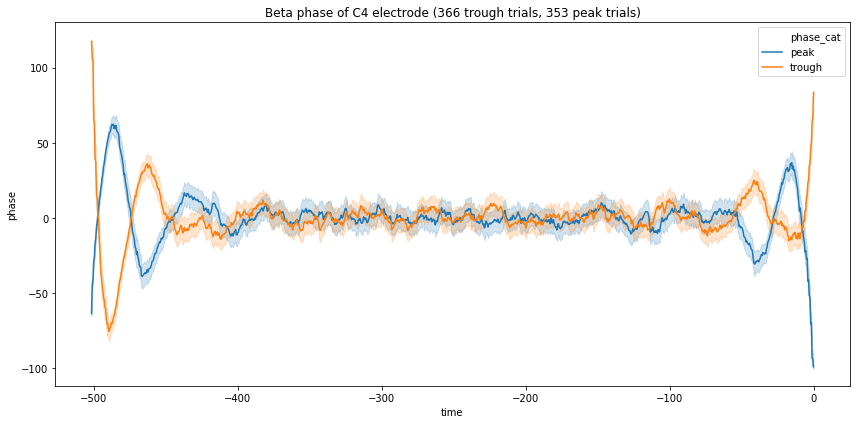

In [275]:
time_point_count = pickle.load(open(os.path.dirname(eegs[0]) + "/05-clean-prestimulus.p", "rb"))[0]['time'].shape[0]
trough_count = int(df_phase[df_phase['phase_cat'] == 'trough'].shape[0] / time_point_count)
peak_count = int(df_phase[df_phase['phase_cat'] == 'peak'].shape[0] / time_point_count)
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x="time", y="phase", hue="phase_cat", data=df_phase[df_phase['phase_cat'] != 'n/a'], ax=ax)
ax.set_title(global_band + ' phase of ' + global_electrode + ' electrode (' + str(trough_count) + ' trough trials, ' + str(peak_count) + ' peak trials)')
plt.tight_layout()

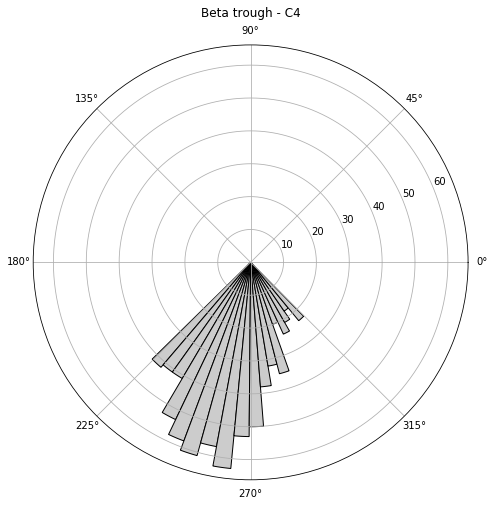

In [277]:
global_cat = 'trough'
degrees = df_phase[(df_phase['phase_cat'] == global_cat) * (df_phase['time'] == 0)]['phase'].values + 180
radians = np.deg2rad(degrees)

bin_size = 5
a, b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='polar')
ax.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, color='.8', edgecolor='k')
ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_title(global_band + ' ' + global_cat + ' - ' + global_electrode)
plt.show()